<a href="https://colab.research.google.com/github/lucadonnoh/progetto-deblur/blob/main/Progetto_Deblur_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [1]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=7, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n)) 
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=7, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

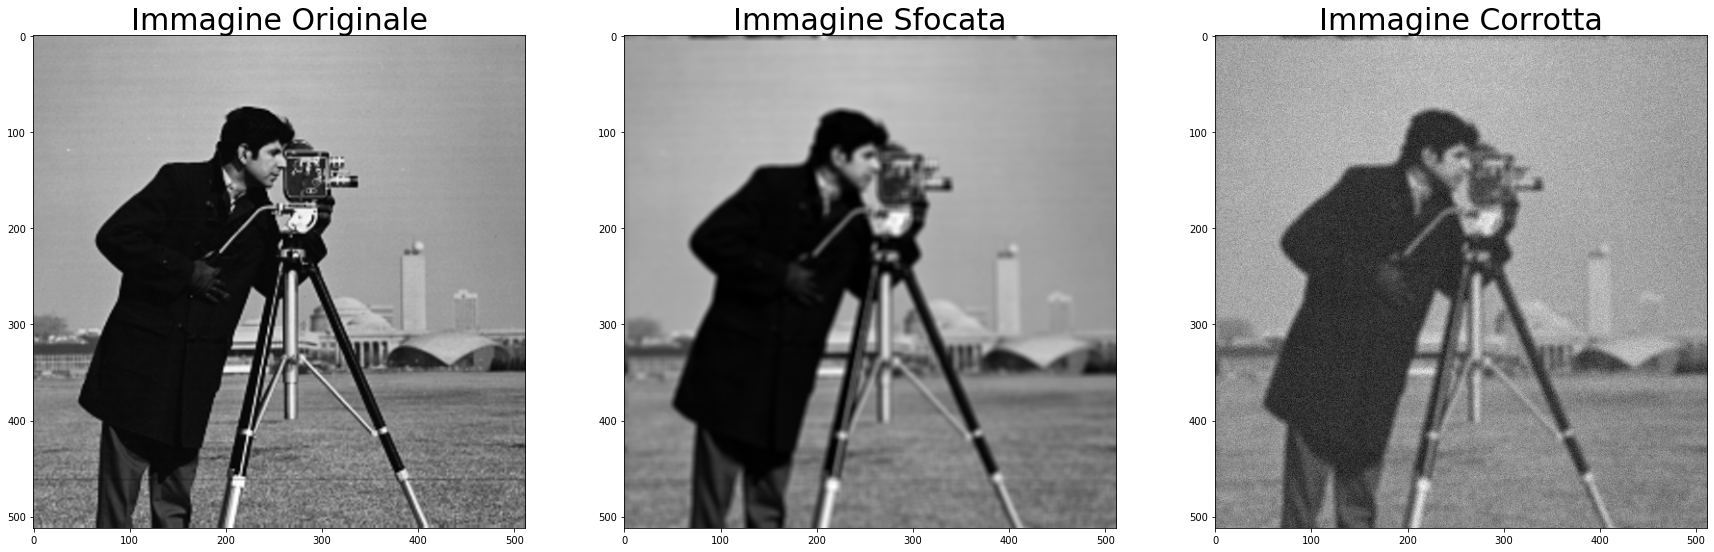

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters

# 1
X = data.camera()
m, n = X.shape
x = X.reshape(m*n) # array m*n


# 2
X_blur = A(X) # matrice
x_blur = X_blur.reshape(m*n) # array


# 3
# Generiamo il rumore eta
sigma = 0.1 # Varianza del rumore
eta = np.random.normal(size=X_blur.shape) # random gaussian distribution
eta /= np.linalg.norm(eta, 'fro') # norma di frobenius
eta *= sigma * np.linalg.norm(X_blur,'fro')

# Aggiungiamo il rumore all'immagine sfocata
B = X_blur + eta
b = B.reshape(m*n)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(X_blur, cmap='gray')
plt.title('Immagine Sfocata', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

plt.show()

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [5]:
# 4 - 5 
#Modificare l'algoritmo è stato interpretato come "sovrascrivere il precedente"

def f(x, b): #
  return 0.5*(np.linalg.norm(A(x)-b))**2

def grad_f(x, b):
  return AT(A(x)-b)

def next_step(x, b, f, grad):
  alpha = 0.5
  rho = 0.5
  c1 = 0.25
  k = 0

  while f(x-alpha*grad, b) > f(x, b) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize(x0, x_true, b, maxit, abstop):
  x = x0
  grad = grad_f(x, b)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step(x, b, f, grad) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f(x, b)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
    k += 1
    print(".", end='')

  err = err[0:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


..................................................
 [12045.69101879 10931.81119303 10322.0814917   9960.2462607
  9731.31722475  9580.75569444  9480.52197939  9414.93186149
  9374.5196725   9353.19735866  9346.84074152  9352.53527103
  9368.14793323  9392.07109551  9423.06227142  9460.14006922
  9502.51444515  9549.53865851  9600.67538011  9655.47227859
  9713.54410194  9774.55930248  9838.22989857  9904.30368048
  9972.55813991 10042.79568414 10114.83982016 10188.53207972
 10263.72951671 10340.30265122 10418.13376562 10497.11548059
 10577.14955589 10658.1458728  10740.02156482 10822.70027008
 10906.11148452 10990.18999906 11074.87540709 11160.1116714
 11245.84674153 11332.03221417 11418.62303056 11505.57720572
 11592.8555854  11680.42162709 11768.24120212 11856.2824164
 11944.51544736 12032.91239554]


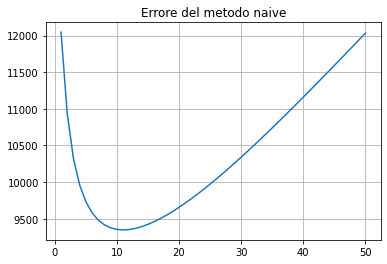

...........[9346.84074152]


In [14]:
def plot( iters, error, title): 
  err_iteration = np.linspace(1, iters, error.size)
  plt.plot(err_iteration, error)
  plt.title(title)
  plt.grid()
  plt.show()

def find_x(error):
  return np.where(error == np.amin(error))[0]

MAXITERATIONS=50
ABSOLUTE_STOP=1.e-5

x_naive, ite_naive, err_naive = minimize(B, X, B, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_naive)
plot(ite_naive, err_naive,"Errore del metodo naive")

X_trunc_index = find_x(err_naive)
X_trunc,_,erroredio= minimize(B,X,B,X_trunc_index+1, ABSOLUTE_STOP)
print(err_naive[X_trunc_index])

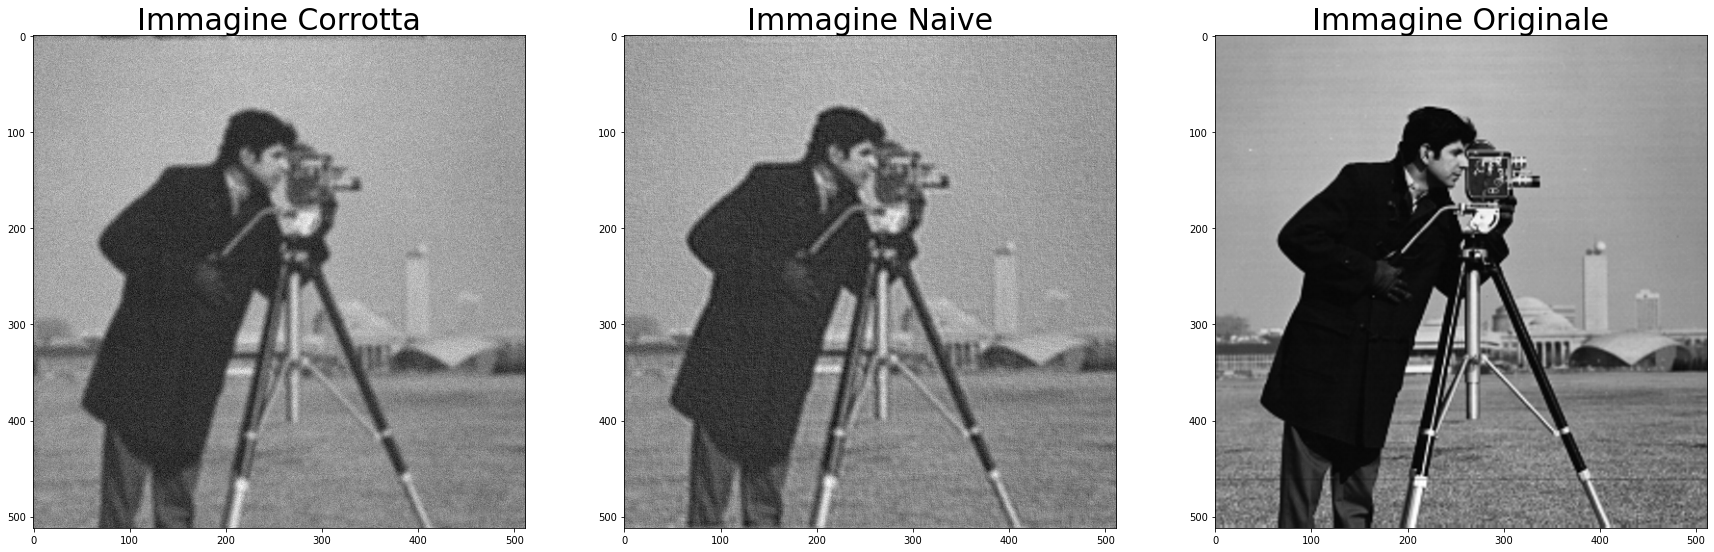

In [15]:
#Plottiamo il risultato
plt.figure(figsize=(30, 10))

fig1 = plt.subplot(1, 3, 1)
fig1.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig2 = plt.subplot(1, 3, 2)
fig2.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig3 = plt.subplot(1, 3, 3)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [16]:
def f_reg(x, b, lamb):
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2

def grad_f_reg(x, b, lamb):
  return AT(A(x)-b) + lamb*x

def next_step_reg(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg(x-alpha*grad, b, lamb) > f_reg(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    #print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)


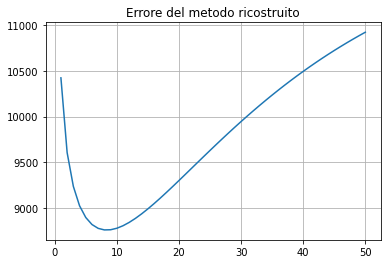

[8757.05100657]


In [17]:
def lambottimale(x, b, max):
  lamb=0.00000001
  k=0
  x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
  rat = 1.1
  while np.linalg.norm(A(x)-b)**2 <= np.linalg.norm(eta)**2:
    lamb *= rat
    x,_,_ = minimize_reg(B,X,B,lamb, max, ABSOLUTE_STOP)
    k+=1
    print(",", end='')
  print("it: ", k)
  return lamb/rat

lamb = 0.02155582137126536 #lambda in modo euristico

(x_reg, ite_reg, err_reg) = minimize_reg(B, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
#print("\n", err_reg)
plot(ite_reg, err_reg,"Errore del metodo ricostruito")

X_reg_index = find_x(err_reg)
print(err_reg[X_reg_index])
X_lambda,_,_= minimize_reg(B, X, B, lamb, X_reg_index+1, ABSOLUTE_STOP)



 [10425.13093394  9605.4384236   9234.96704453  9021.79490729
  8893.25010203  8816.22240217  8774.07832367  8757.05100657
  8758.87751424  8775.2437157   8803.01729174  8839.83149253
  8883.8436069   8933.58620799  8987.87076962  9045.72238117
  9106.3337784   9169.03186408  9233.25260494  9298.52173695
  9364.43962181  9430.66915256  9496.92595363  9562.97034471
  9628.60068572  9693.6478203   9757.97040502  9821.45096088
  9883.99251932  9945.51576191 10005.95657247 10065.26393596
 10123.39813039 10180.32916743 10236.03544474 10290.50257946
 10343.72239681 10395.69205219 10446.41326814 10495.89167058
 10544.13621093 10591.15866266 10636.97318238 10681.59592719
 10725.04472091 10767.33876292 10808.49837431 10848.5447765
 10887.49989828 10925.38620787]


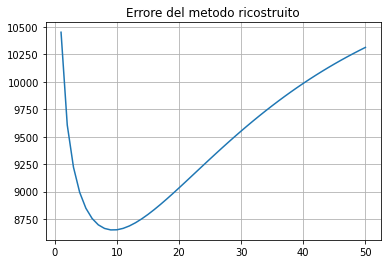

[8650.27948218]


In [19]:
lamb_disc = 0.025625815225418787 #lamda tramite condizione discrepanza

x0 = np.zeros(X.shape) # immagine ricostruita al passo 0
(X_reg2, ite_reg2, err_reg2) = minimize_reg(B, X, B, lamb_disc, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg)
plot(ite_reg2, err_reg2,"Errore del metodo ricostruito")

X_reg_index2 = find_x(err_reg2)
print(err_reg2[X_reg_index2])
X_lambda_disc,_,_= minimize_reg(B, X, B, lamb_disc, X_reg_index+1, ABSOLUTE_STOP)

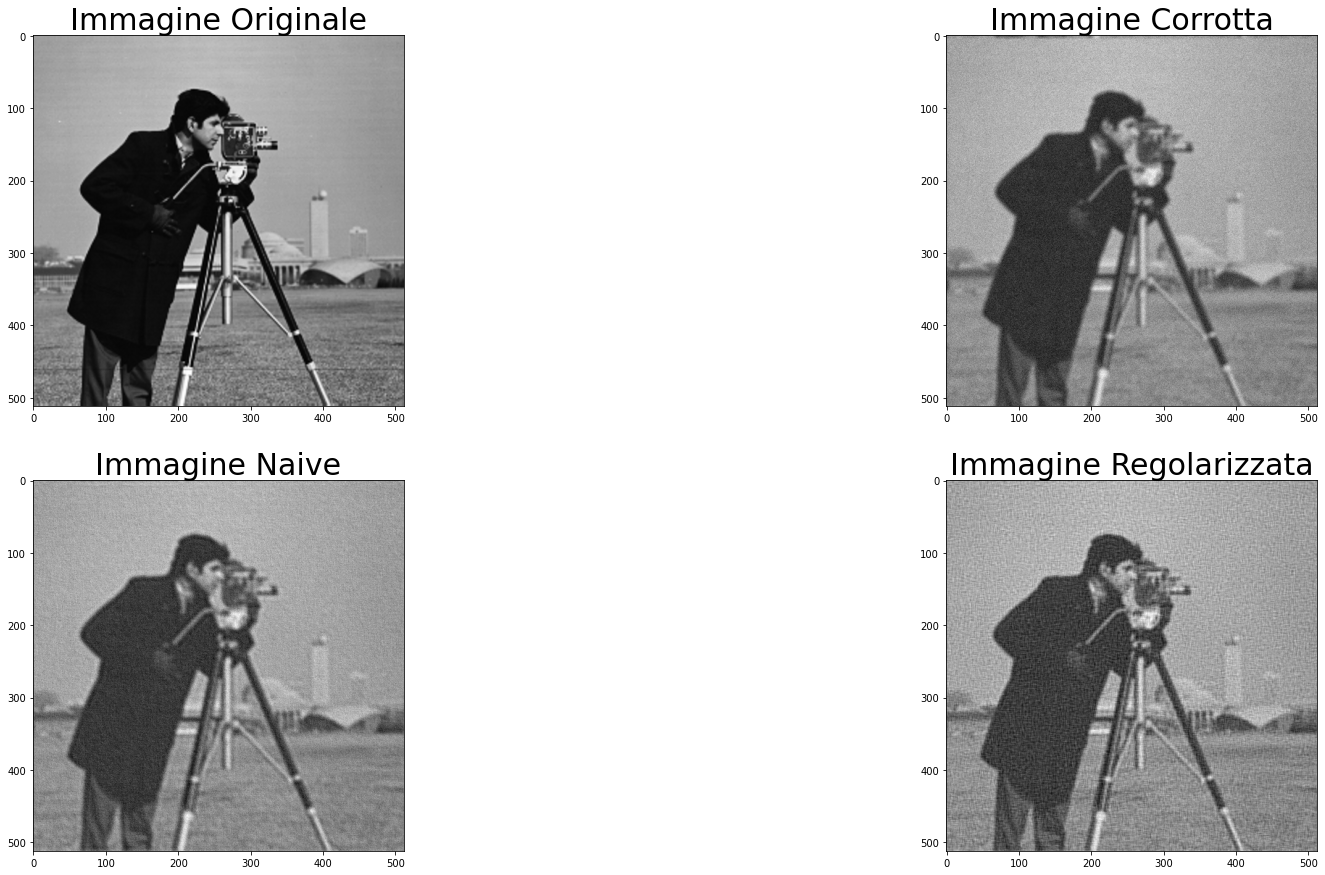

In [ ]:
#Plottiamo il risultato
plt.figure(figsize=(30, 15))

fig0 = plt.subplot(2, 2, 2)
fig0.imshow(B, cmap='gray')
plt.title('Immagine Corrotta', fontsize=30)

fig1 = plt.subplot(2, 2, 3)
fig1.imshow(X_trunc, cmap='gray')
plt.title('Immagine Naive', fontsize=30)

fig2 = plt.subplot(2, 2, 4)
fig2.imshow(X_reg, cmap='gray')
plt.title('Immagine Regolarizzata', fontsize=30)

fig3 = plt.subplot(2, 2, 1)
fig3.imshow(X, cmap='gray')
plt.title('Immagine Originale', fontsize=30)

plt.show()

8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [20]:
def f_reg_1(x, b, lamb): #
  return 0.5*(np.linalg.norm(A(x)-b))**2 + lamb*np.linalg.norm(x, 1)**2

def grad_f_reg_1(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_1(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_1(x-alpha*grad, b, lamb) > f_reg_1(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_1(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_1(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_1(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_1(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

..................................................
 [10430.11723146  9723.86907978  9449.79679555  9342.46717245
  9322.32653347  9355.73710158  9425.48998457  9521.57837831
  9637.61714153  9641.48645734  9642.45584831  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311  9642.45586311  9642.45586311
  9642.45586311  9642.45586311]


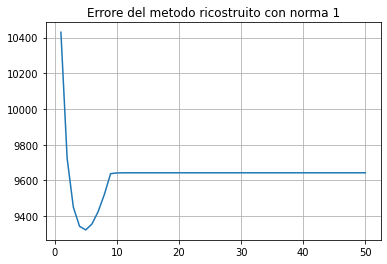

[9322.32653347]
.....

In [22]:
#Punto 8,  norma 1

lamb = 0.025625815225418787 #lamda tramite condizione discrepanza

(x_rec_1, ite_rec_1, err_reg_1) = minimize_reg_1(B, X, B, lamb, MAXITERATIONS, ABSOLUTE_STOP) #anche se nelle funzioni viene utilizzato 'x' viene passata 'X' ovvero la matrice dell'immagine
print("\n", err_reg_1)
plot(ite_rec_1, err_reg_1,"Errore del metodo ricostruito con norma 1")

X_reg_index = find_x_trunc(err_reg_1)
print(err_reg_1[X_reg_index])
X_lambda,_,_= minimize_reg_1(B, X, B, lamb, X_reg_index+1, ABSOLUTE_STOP)

9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [ ]:
#TODO: va definito mu
#TODO: va anche trovato il gradiente, davide dice che dobbiam esser bravi a trovarcelo

def f_reg_mista(x, b, lamb): 
  return 0.5*(np.linalg.norm(A(x)-b))**2 + 0.5*lamb*np.linalg.norm(x)**2 + mu*np.linalg.norm(x1,1)

def grad_f_reg_mista(x, b, lamb):
  return AT(A(x)-b) + lamb*np.sign(x)

def next_step_reg_mista(x, b, f, grad, lamb):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  k = 0

  while f_reg_mista(x-alpha*grad, b, lamb) > f_reg_mista(x, b, lamb) - alpha * c1 * np.linalg.norm(grad, 'fro') ** 2:
    alpha *= rho
    k += 1
  
  return alpha;

def minimize_reg_mista(x0, x_true, b, lamb, maxit, abstop):
  x = x0
  grad = grad_f_reg_mista(x, b, lamb)
  err = np.zeros(maxit) #errore alla k-esima iterazione

  k = 0
  while (np.linalg.norm(grad) > abstop) and (k < maxit):
    x = x + next_step_reg_mista(x, b, f, grad, lamb) * (-grad) # x + passo*direzione (-gradiente ovvero massima decrescita)
    grad = grad_f_reg_mista(x, b, lamb)
    err[k]  = np.linalg.norm(x_true - x)  #distanza con la norma2, prima fa la differenza membro a membro fra matrici poi ne calcola la norma2
                                          #TODO: in teoria si potrebbe trasformare entrambi le matrici in vettori e poi farne la distanza ma ha senso? 
    k += 1
    print(".", end='')

  err = err[:k]  #l'ultima iterazione è esclusa perchè l'estremo destro viene escluso
  return(x, k, err)

In [ ]:
#trovare il lamba ottimale

---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

